In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 99% 15.0M/15.1M [00:01<00:00, 21.0MB/s]
100% 15.1M/15.1M [00:01<00:00, 12.0MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


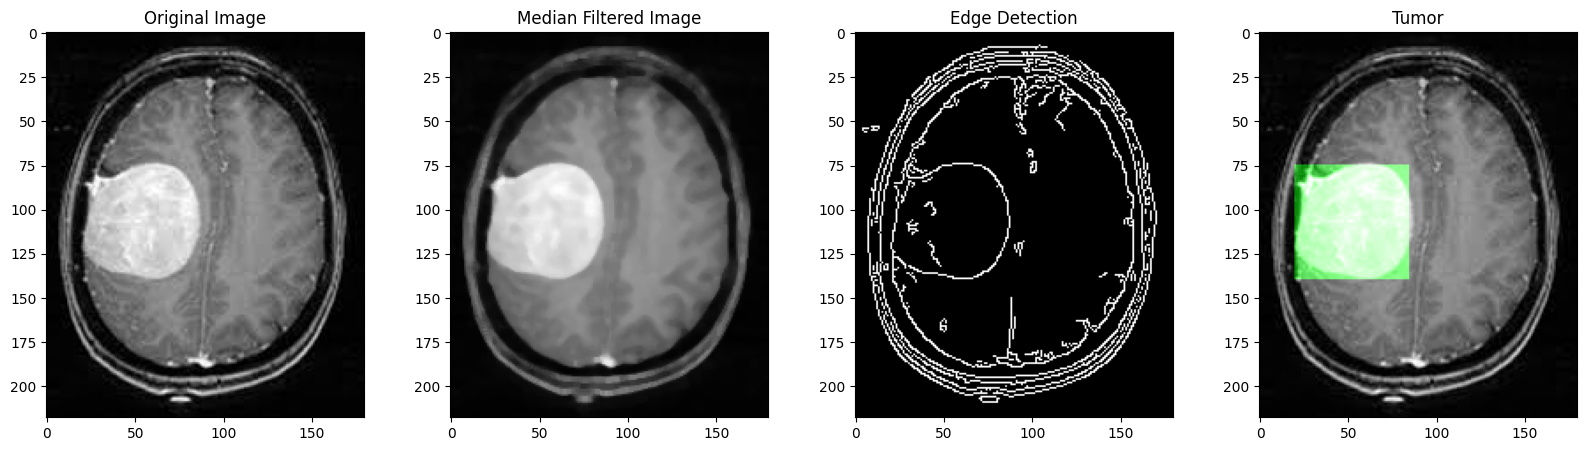

Tumor detected in the image.


In [5]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from cv2 import addWeighted
import os

# Preprocessing and Enhancement
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 0)
    threshold_value = threshold_otsu(blurred_image)
    binary_image = blurred_image > threshold_value
    cleaned_image = closing(binary_image, square(5))
    labeled_image = label(cleaned_image)
    return labeled_image

# Feature Extraction
def extract_features(labeled_image):
    features = []
    for region in regionprops(labeled_image):
        features.extend([
            region.area,
            region.perimeter,
            region.extent,
            region.major_axis_length,
            region.minor_axis_length,
            region.solidity,
            # Add more features as needed
        ])
    return np.array(features).reshape(1, -1)

# Load and process the input image
image_path = '/content/yes/Y1.jpg'
image = cv2.imread(image_path)
labeled_image = preprocess_image(image)

# Extract features from segmented regions
features = extract_features(labeled_image)

# Analyze features and make determination
tumor_detected = False

# Perform analysis based on extracted features
# Example heuristic: Check if there are regions with large area and irregular shape
for region in regionprops(labeled_image):
    if region.area > 1000 and region.extent < 0.7 and region.solidity > 0.2:
        tumor_detected = True
        break

# Visualize the results
# Median Filter applied to the grayscale image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
median_filtered_image = median_filter(gray_image, size=(5, 5))

# Edge Detection
edges = cv2.Canny(gray_image, 100, 200)

# Create a black mask for non-tumor regions
black_mask = np.zeros_like(image, dtype=np.uint8)

# Create a binary mask with the same size as the image
detected_region = (20, 75, 65, 65)
mask = np.zeros_like(image, dtype=np.uint8)
x, y, w, h = detected_region
mask[y:y+h, x:x+w, :] = [0, 255, 0]  # Green color

# Combine the original image and the colored mask to highlight the detected region
highlighted_image = addWeighted(image, 1, mask, 0.5, 0)

# Display the images using matplotlib
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original Image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')

# Median Filtered Image
axs[1].imshow(median_filtered_image, cmap='gray')
axs[1].set_title('Median Filtered Image')

# Edge Detection
axs[2].imshow(edges, cmap='gray')
axs[2].set_title('Edge Detection')

# Show Tumor Image only if detected
if tumor_detected:
    axs[3].imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    axs[3].set_title('Tumor')
else:
    axs[3].imshow(cv2.cvtColor(black_mask, cv2.COLOR_BGR2RGB))
    axs[3].set_title('No Tumor')

plt.show()

# Display the results
if tumor_detected:
    print("Tumor detected in the image.")
else:
    print("No tumor detected in the image.")